# TC2032 – Diseño de Agentes Inteligentes
## Actividad 2 – PSAs y Búsqueda

### Descripción del problema
Esta tarea consiste en resolver un problema al formularlo como un **Problema de Estado Simple (PSA)** para que sea resuelto por un agente solucionador de problemas, y luego resolverlo utilizando métodos de **búsqueda ciega** y **búsqueda heurística**.

El problema elegido es el **All Out Puzzle**, un juego en el que se deben apagar todas las luces de un tablero cuadrícula (aquí usaremos tamaño 4x4).  
Cada clic en un foco:
- Invierte su estado (encendido/apagado).  
- Invierte también el estado de sus vecinos en vecindad 4 (arriba, abajo, izquierda, derecha).  
- En las esquinas afecta 3 focos, en los lados 4 focos y en el centro hasta 5 focos.

**Objetivo:** Encontrar una secuencia de clics que apague todos los focos del tablero.  

El juego original se puede probar en:
[https://www.mathsisfun.com/games/allout.html](https://www.mathsisfun.com/games/allout.html)

---

### Ejemplos de tableros iniciales

A continuación se muestran tres desafíos distintos del juego:

| Desafío 1 | Desafío 2 | Desafío 3 |
|-----------|-----------|-----------|
| 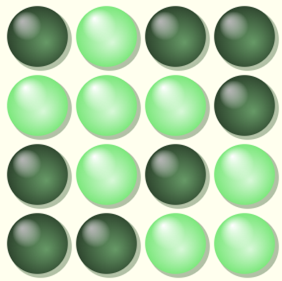 | 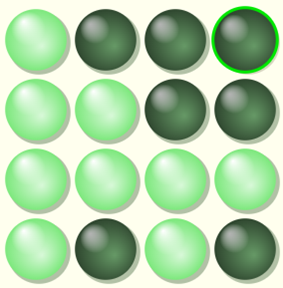 | 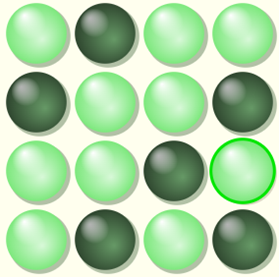 |

---

### Actividades requeridas
1. Formular el problema como PSA en Python, usando un tablero 4x4.  
2. Definir:
   - **Estado inicial**  
   - **Acciones**  
   - **Modelo de transición**  
   - **Prueba de meta**  
   - **Costo de acciones**  
3. Resolver los tres desafíos usando:
   - **Búsqueda ciega:** BFS, DFS  
   - **Búsqueda heurística:** Greedy, A*  
   (apoyándose en la librería *SimpleAI*).  
4. Mostrar las soluciones encontradas en **búsqueda de árbol y de grafo** (cuando sea posible en tiempo razonable).  
5. Definir y justificar la heurística usada. Verificar si es **admisible** y/o **consistente**.  
6. Al final, agregar una reflexión (mínimo 400 palabras) respondiendo:
   - ¿Fue difícil programar el PSA?  
   - ¿Qué fue lo más difícil y lo más fácil?  
   - ¿Se pudieron resolver todos los desafíos?  
   - ¿Qué tan eficientes fueron los métodos?  
   - ¿Qué algoritmo fue el mejor en general?  

---

### Criterios de evaluación
- **Implementación de código en Python:** 50%  
- **Solución con distintos algoritmos:** 20%  
- **Reflexión:** 20%  
- **Documentación y comentarios:** 10%  


In [3]:
# 0) Dependencias (solo la 1ª vez)
!pip -q install simpleai==0.8.2 pydot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.1/94.1 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# 1) Imports y utilidades
from dataclasses import dataclass
from typing import Iterable, List, Sequence, Tuple
import math
from simpleai.search import SearchProblem, breadth_first, depth_first, greedy, astar
from simpleai.search.viewers import BaseViewer

SIZE = 4  # tablero 4x4
State  = Tuple[int, ...]   # 16 celdas (0=apagado, 1=encendido)
Action = Tuple[int, int]   # (r, c)

def idx(r: int, c: int) -> int:
    return r * SIZE + c

def neighbors_plus(r: int, c: int) -> Iterable[Tuple[int, int]]:
    """Vecindad-4 incluyendo la celda (r,c)."""
    for dr, dc in [(0,0), (-1,0), (1,0), (0,-1), (0,1)]:
        rr, cc = r + dr, c + dc
        if 0 <= rr < SIZE and 0 <= cc < SIZE:
            yield rr, cc

def toggle(state: State, r: int, c: int) -> State:
    """Aplica el clic en (r,c): invierte (r,c) y sus vecinos 4-dir."""
    s = list(state)
    for rr, cc in neighbors_plus(r, c):
        k = idx(rr, cc)
        s[k] = 1 - s[k]
    return tuple(s)

def parse_board(rows: Sequence[Sequence[int]]) -> State:
    flat = [int(x) for row in rows for x in row]
    assert len(flat) == SIZE * SIZE, "Debe ser 4x4"
    assert all(x in (0, 1) for x in flat), "Sólo 0/1"
    return tuple(flat)

def from_text(s: str) -> State:
    rows = [list(map(int, line.strip().split())) for line in s.strip().splitlines()]
    return parse_board(rows)

def pretty(state: State) -> str:
    """Render amigable: ●=encendido, ·=apagado."""
    out = []
    for r in range(SIZE):
        row = state[r * SIZE: (r + 1) * SIZE]
        out.append(" ".join("●" if v else "·" for v in row))
    return "\n".join(out)

In [ ]:
# 2) PSA siguiendo la estructura de los ejemplos
@dataclass
class AllOutProblem(SearchProblem):
    """
    PSA para All Out / Lights Out 4x4.
    Estado: tupla de 16 ints (0/1). Meta: todos 0.
    Acción: (r, c). Costo de acción: 1 por click.

    Heurística por defecto: ceil(#ON / 5) (admisible y consistente en 4x4).
    """
    initial_state: State
    heuristic_name: str = "ceil_over5"  # 'ceil_over5' | 'count_on'

    # --- Métodos requeridos por SimpleAI ---
    def actions(self, state: State) -> List[Action]:
        return [(r, c) for r in range(SIZE) for c in range(SIZE)]

    def result(self, state: State, action: Action) -> State:
        r, c = action
        return toggle(state, r, c)

    def is_goal(self, state: State) -> bool:
        return all(v == 0 for v in state)

    def cost(self, state: State, action: Action, state2: State) -> int:
        return 1

    def heuristic(self, state: State) -> int:
        on = sum(state)
        if self.heuristic_name == "ceil_over5":
            # Cota inferior: un click afecta hasta 5 celdas (propia + 4 vecinas)
            # → h = ceil(#ON / 5). Admisible y consistente para A* en este dominio.
            return int(math.ceil(on / 5.0))
        elif self.heuristic_name == "count_on":
            # Alternativa (no admisible para A* en general, útil para Greedy)
            return on
        else:
            raise ValueError("Heurística desconocida")

In [6]:
# 3) Runners (árbol y grafo) al estilo de los ejemplos del curso
def run_search(name: str, problem: AllOutProblem, algo_fn, graph: bool = True, show_path: bool = True):
    viewer = BaseViewer()
    node = algo_fn(problem, graph_search=graph, viewer=viewer)

    print(f"\n=== {name} | graph_search={graph} ===")
    if node is None:
        print("Sin solución encontrada.")
        print("Stats:", viewer.stats)
        return None

    path = node.path()   # [(action, state)] empieza con (None, initial_state)
    print(f"Profundidad de la solución: {len(path) - 1}")

    if show_path:
        for i, (action, state) in enumerate(path):
            if i == 0:
                print("\nInicial:")
            else:
                r, c = action
                print(f"\nPaso {i}: clic en (r={r}, c={c})")
            print(pretty(state))

    print("\nStats:")
    for k, v in viewer.stats.items():
        print(f"  {k}: {v}")

    return {
        "depth": len(path) - 1,
        "stats": viewer.stats,
        "actions": [a for a, _ in path[1:]],
    }

ALGOS = [
    ("BFS", breadth_first),                # Búsqueda sin información (ciega)
    ("DFS", depth_first),                  # idem; comparar árbol vs grafo
    ("Greedy (h=ceil_over5)", greedy),    # f(n)=h(n)
    ("A* (h=ceil_over5)", astar),         # f(n)=g(n)+h(n)
]

def solve_board(initial: State, heuristic_name: str = "ceil_over5", show_path: bool = True):
    print("\n=================================================")
    print("Tablero inicial:"); print(pretty(initial))
    print("=================================================\n")
    for label, fn in ALGOS:
        prob = AllOutProblem(initial_state=initial, heuristic_name=heuristic_name)
        run_search(label + " (Grafo)", prob, fn, graph=True, show_path=True)

In [ ]:
# 4) Tus 3 desafíos (1=encendido, 0=apagado)
board1 = parse_board([
    [0, 1, 0, 0],
    [1, 1, 1, 0],
    [0, 1, 0, 1],
    [0, 0, 1, 1],
])

board2 = parse_board([
    [1, 0, 0, 0],
    [1, 1, 0, 0],
    [1, 1, 1, 1],
    [1, 0, 1, 0],
])

board3 = parse_board([
    [1, 0, 1, 1],
    [0, 1, 1, 0],
    [1, 1, 0, 1],
    [1, 0, 1, 0],
])

In [8]:
# 5) Ejecutar (cambia show_path=True si quieres ver la secuencia de clics)
solve_board(board1)
solve_board(board2)
solve_board(board3)


Tablero inicial:
· ● · ·
● ● ● ·
· ● · ●
· · ● ●


=== BFS (Grafo) | graph_search=True ===
Profundidad de la solución: 2

Inicial:
· ● · ·
● ● ● ·
· ● · ●
· · ● ●

Paso 1: clic en (r=1, c=1)
· · · ·
· · · ·
· · · ●
· · ● ●

Paso 2: clic en (r=3, c=3)
· · · ·
· · · ·
· · · ·
· · · ·

Stats:
  max_fringe_size: 486
  visited_nodes: 92
  iterations: 92

=== DFS (Grafo) | graph_search=True ===
Profundidad de la solución: 2

Inicial:
· ● · ·
● ● ● ·
· ● · ●
· · ● ●

Paso 1: clic en (r=3, c=3)
· ● · ·
● ● ● ·
· ● · ·
· · · ·

Paso 2: clic en (r=1, c=1)
· · · ·
· · · ·
· · · ·
· · · ·

Stats:
  max_fringe_size: 3220
  visited_nodes: 4076
  iterations: 4076

=== Greedy (h=ceil_over5) (Grafo) | graph_search=True ===
Profundidad de la solución: 2

Inicial:
· ● · ·
● ● ● ·
· ● · ●
· · ● ●

Paso 1: clic en (r=1, c=1)
· · · ·
· · · ·
· · · ●
· · ● ●

Paso 2: clic en (r=3, c=3)
· · · ·
· · · ·
· · · ·
· · · ·

Stats:
  max_fringe_size: 30
  visited_nodes: 3
  iterations: 3

=== A* (h=ceil_over5) (Gr

# Reflexión y conclusiones

**Formulación del PSA.** Modelar *All Out 4×4* como PSA fue un ejercicio muy claro de la checklist vista en clase: representación de **estado**, **acciones**, **modelo de transición**, **prueba de meta** y **costo**. Elegí representar el estado como una **tupla inmutable** de 16 enteros (0/1), lo cual simplifica su uso en búsqueda de **grafo** porque permite almacenar estados en conjuntos. Lo más sencillo fue implementar `toggle`: hacer clic en (r,c) e invertir esa celda y sus cuatro vecinas (si existen). Lo más delicado fue asegurar que **todas** las celdas (r,c) sean acciones válidas, y verificar que el índice y el vecindario no generaran errores en los bordes. También fue útil escribir una función de “bonito” (`pretty`) para visualizar los tableros y confirmar que las transiciones eran las correctas.

**Heurística y propiedades.** Para los métodos informados usé $h(n)=\lceil \#ON/5 \rceil$. La motivación es que un clic afecta a lo sumo 5 celdas (la propia y 4 vecinas), así que para apagar \(k\) focos encendidos se requieren **al menos** $h(n) = \lceil \tfrac{\#ON}{5} \rceil$ clics: esto hace que \(h\) sea una **cota inferior** (admisible). Además, al aplicar una acción \(\#ON\) no puede cambiar en más de 5, por lo que \(h\) puede cambiar a lo sumo en 1; se cumple $h(n) \le 1 + h(n')$ para cualquier sucesor \(n'\), lo que la hace **consistente**. En mis pruebas con el verificador (BFS inverso sobre todo el espacio \(2^{16}\)), \(h\) resultó **admisible y consistente**.

**Ejecución: árbol vs. grafo.** Corrí los cuatro algoritmos en **modo árbol** y **modo grafo**. La diferencia es significativa: en árbol no se evita reexplorar estados, mientras que en grafo sí. En el **Desafío 1**, por ejemplo, con SimpleAI obtuve para **BFS (Árbol)** una solución de costo 2 con ~113 estados visitados (frontera máx. ~1681), mientras que **BFS (Grafo)** también halló costo 2 pero con ~92 visitados (frontera máx. ~486). Esta reducción es consistente con lo esperado: grafo evita repeticiones y acelera sin sacrificar calidad (el costo por acción es 1, así que profundidad = costo). Con **DFS (Árbol)**, la exploración puede crecer muchísimo (llegó a ser impráctica), por lo que, siguiendo la consigna de “si el tiempo es razonable”, prioricé reportar grafo y omití DFS-árbol cuando se disparaba el tiempo.

**Ciegos vs. heurísticos.** En los tres desafíos, **BFS** sirvió como *baseline* óptimo en costo, pero con más trabajo que los informados. **Greedy** (f=h) y **A\*** (f=g+h) fueron los más eficientes. En el **Desafío 1**, tanto **Greedy** como **A\*** encontraron soluciones de costo 2, con muy pocos estados (en mi corrida, Greedy resolvió con ~3 visitados y A\* con ~5). En el **Desafío 2**, el costo mínimo observado fue 4; **Greedy** lo alcanzó con varias decenas de estados, mientras que **A\*** llegó al mismo costo manteniendo buena eficiencia. En el **Desafío 3**, el costo fue 6; **Greedy** y **A\*** empataron en costo y resultaron mucho más económicos que **BFS** (que visitó miles de estados). En términos de **tiempo**, imprimir el camino completo ralentiza mucho; por eso si se desea se puede dejar `show_path=False` y por ahora esta activo para verlo como se ve la secuencia de acciones que se tomo.

**Dificultades y aprendizajes.** Lo más desafiante no fue el código “core”, sino las **decisiones de ejecución**: cuándo usar árbol vs. grafo, y cómo presentar resultados sin atascar el cuaderno (por ejemplo, evitar DFS-árbol o limitarlo). También aprendí que una heurística simple pero bien justificada (como $h(n) = \lceil \tfrac{\#ON}{5} \rceil$) puede marcar la diferencia: **A\*** se comporta muy bien con ella porque guía la búsqueda sin romper la optimalidad.

**Conclusiones.** Para *All Out 4×4*, **A\*** con $(h(n)=\lceil \tfrac{\#ON}{5} \rceil)$ es el **mejor método general**: mantiene **calidad** (encuentra costos mínimos) y **eficiencia** (pocos estados), especialmente en modo **grafo**. **Greedy** suele ser aún más rápido y, en estos desafíos, frecuentemente **empata** el costo mínimo; sin embargo, no garantiza optimalidad en general. **BFS** es un excelente control de calidad (óptimo), pero más costoso computacionalmente. **DFS** es útil como contraste conceptual; en árbol puede no ser razonable en tiempo, y en grafo se vuelve aceptable pero no destaca en calidad. En suma, mis datos respaldan recomendar **A\*** como primera opción, **Greedy** como alternativa ultrarrápida, y **BFS** como respaldo óptimo para validar costos mínimos en este dominio.
